# Formulação

Vehicle routing proble with time windows

- $C$: conjunto de clientes
- $N = \{0\} \cup C$: conjunto de vértices, onde 0 representa o centro de distribuiçõa.
- $A = \{ (i,j) \in \mathbb{N} \times \mathbb{N} \ : \ i \not= j  \}$: conjunto dos arcos entre cada vértice.
- $q_i$: volume ou demanda de cada cliente.
- $Q$: capacidade dos veículos.
- $K = \{ 1,2, \ldots, n \}$, conjunto dos veículos.

# Variáveis

$
x_{i,j,k} = 
\left\{
\begin{array}{lr}
1, \mbox{ se o arco } (i,j) \in A \mbox{ é usado pelo veículo } k. \\
0, \mbox{ caso contrário}
\end{array}
\right.
$

$t_{ik}$, tempo em que se inicia o serviço no vértice $i \in N$, com o veículo $k \in K$

# Modelo

\begin{align*}
z = \min & \sum_{k \in K} \sum_{(i,j) \in A} c_{i,j,k} x_{i,j,k} \\
& \sum_{j \in C} x_{0,j,k} \leq 1 \ \forall k \in K \\
& \sum_{i \in C} x_{i,0,k} \leq 1 \ \forall k \in K \\
& \sum_{j \in N} \sum_{k \in K} x_{i,j,k} = 1 \ \forall i \in C \\
& \sum_{j \in N} x_{i,j,k} - \sum_{j \in N} x_{j,i,k} = 0 \ \forall k \in K, \ \forall i \in C \\
& \sum_{i \in C} q_i \sum_{j \in N} x_{i,j,k} \leq Q, \forall k \in K \\
& \mbox{se } x_{i,j,k} = 1 \to t_{ik} + s_i + T_{i,j} = t_{j,k} \ \forall k \in K, \ \forall (i,j) \in A \\
& e_i \leq t_{i,k} \leq l_{i} \ \forall i \in N, \ \forall k \in K.
\end{align*}

In [1]:
# import bibliotecas
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# vertices
n = 11
C = [i for i in range(n) if i!=0]
N = [0] + C
A = [(i,j) for i in N for j in N if i!=j]

In [12]:
# demanda
np.random.seed(0)
q = {n : np.random.randint(10,15) for n in C}
q[0] = 0

In [13]:
# tempo de vendas

# tempo mínimo de chegada
e = {0:0, 1:10, 2:10, 3:10, 4:20, 5:20, 6:20, 7:40, 8:40, 9:40, 10:40} 

# tempo máximo de chegada
l = {0:200, 1:100, 2:100, 3:100, 4:150, 5:150, 6:150, 7:180, 8:180, 9:180, 10:180}

In [14]:
# tempo de serviço no vértice i
s = {n: np.random.randint(3,5) for n in C}
s[0] = 0

In [15]:
# veículos
K = [1,2,3,4]

In [16]:
# Q = 50
Q = {1:50, 2:50, 3:25, 4:25}

In [17]:
# coordenadas
X = np.random.rand(len(N))*100
Y = np.random.rand(len(N))*100

In [18]:
# distâncias e tempos
distancia = {
    (i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in N for j in N if i!=j
}

tempo = {
    (i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in N for j in N if i!=j
}

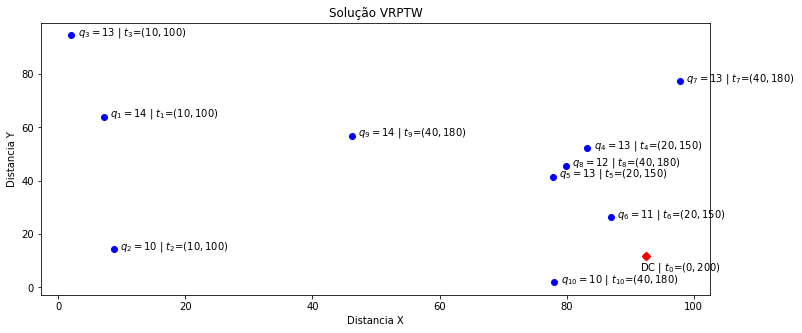

In [25]:
# print grafo
plt.figure(figsize=(12,5))
plt.scatter(X,Y,color='blue')

# DC: centro de distribuição
plt.scatter(X[0],Y[0], color='red',marker='D')
plt.annotate("DC | $t_{%d}$=(%d$,%d$)" %(0,e[0],l[0]),(X[0]-1,Y[0]-5.5))

for i in C:
    plt.annotate('$q_{%d}=%d$ | $t_{%d}$=(%d$,%d$)' %(i,q[i],i,e[i],l[i]),(X[i]+1,Y[i]))

plt.xlabel("Distancia X")
plt.ylabel("Distancia Y")
plt.title("Solução VRPTW")

plt.show()

In [26]:
# Formulação

# arcos para o modelo
arcos = [(i,j,k) for i in N for j in N for k in K if i!=j]

arcos_t = [(i,k) for i in N for k in K]

# modelo
model = Model("VRPTW")

# variáveis
x = model.addVars(arcos, vtype=GRB.BINARY, name='x')
t = model.addVars(arcos_t, vtype=GRB.CONTINUOUS, name='t')

# função objetivo
model.setObjective(quicksum(distancia[i,j]*x[i,j,k] for i,j,k in arcos),GRB.MINIMIZE)

# restrições

# chegada e saída de veículos dos DC
model.addConstrs(quicksum(x[0,j,k] for j in C) <= 1 for k in K)
model.addConstrs(quicksum(x[i,0,k] for i in C) <= 1 for k in K)

# um veículo por vértices
model.addConstrs(quicksum(x[i,j,k] for j in N for k in K if i!=j) == 1 for i in C)

# conservação de fluxo
model.addConstrs(
    quicksum(x[i,j,k] for j in N if i!=j) - quicksum(x[j,i,k] for j in N if i!=j) == 0
    for i in N for k in K
)

# capacidade dos veículos
model.addConstrs(
    quicksum(q[i] * quicksum(x[i,j,k] for j in N if i!=j) for i in C) <= Q[k] for k in K
)

# janela de tempo
# indicator constraint
# eliminação de subtour
model.addConstrs(
    (x[i,j,k]==1) >> (t[i,k]+s[i]+tempo[i,j]==t[j,k]) 
    for i in C for j in C for k in K if i!=j
)

model.addConstrs(t[i,k] >= e[i] for i,k in arcos_t)
model.addConstrs(t[i,k] <= l[i] for i,k in arcos_t)

# parametros
model.Params.TimeLimit = 60
model.Params.MIPGap = 0.1

# resolvendo o problema
model.optimize()

Academic license - for non-commercial use only - expires 2021-09-15
Using license file /opt/gurobi912/gurobi.lic
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 154 rows, 484 columns and 1848 nonzeros
Model fingerprint: 0xa9edf963
Model has 360 general constraints
Variable types: 44 continuous, 440 integer (440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve added 414 rows and 0 columns
Presolve removed 0 rows and 64 columns
Presolve time: 0.06s
Presolved: 568 rows, 420 columns, 4042 nonzeros
Variable types: 102 continuous, 318 integer (318 binary)
Found heuristic solutio

In [27]:
# print solução
print("Função objetivo:", str(round(model.ObjVal,2)))

for v in model.getVars():
    if v.x > 0.9:
        print(str(v.VarName)+" = "+str(round(v.x,2)))

Função objetivo: 587.21
x[0,3,2] = 1.0
x[0,4,1] = 1.0
x[0,5,4] = 1.0
x[0,6,3] = 1.0
x[1,2,2] = 1.0
x[2,10,2] = 1.0
x[3,1,2] = 1.0
x[4,7,1] = 1.0
x[5,8,4] = 1.0
x[6,0,3] = 1.0
x[7,9,1] = 1.0
x[8,0,4] = 1.0
x[9,0,1] = 1.0
x[10,0,2] = 1.0
t[1,1] = 10.0
t[1,2] = 43.9
t[1,3] = 42.13
t[1,4] = 10.0
t[2,1] = 10.0
t[2,2] = 96.58
t[2,3] = 42.13
t[2,4] = 10.0
t[3,1] = 10.0
t[3,2] = 10.0
t[3,3] = 100.0
t[3,4] = 10.0
t[4,1] = 20.0
t[4,2] = 150.0
t[4,3] = 20.0
t[4,4] = 20.0
t[5,1] = 32.35
t[5,2] = 150.0
t[5,3] = 20.0
t[5,4] = 32.35
t[6,1] = 20.0
t[6,2] = 59.95
t[6,3] = 40.6
t[6,4] = 40.6
t[7,1] = 53.16
t[7,2] = 86.51
t[7,3] = 40.0
t[7,4] = 70.9
t[8,1] = 125.65
t[8,2] = 88.1
t[8,3] = 40.0
t[8,4] = 40.0
t[9,1] = 112.82
t[9,2] = 40.0
t[9,3] = 70.6
t[9,4] = 40.0
t[10,1] = 179.37
t[10,2] = 170.03
t[10,3] = 40.0
t[10,4] = 83.45


# Gráfico da solução

In [35]:
rotas = list()
caminhoes = list()
Kaux = K
Naux = N
for k in K:
    for i in N:
        if i!=0 and x[(0,i,k)].x > 0.9:
            aux = [0,i]
            while i!=0:
                j = i
                for h in N:
                    if j!=h and x[(j,h,k)].x > 0.9:
                        aux.append(h)
                        i = h
            rotas.append(aux)
            caminhoes.append(k)
print(rotas)
print(caminhoes)

[[0, 4, 7, 9, 0], [0, 3, 1, 2, 10, 0], [0, 6, 0], [0, 5, 8, 0]]
[1, 2, 3, 4]


In [36]:
# calculo dos tempos
tempo_acum = list()
for n in range(len(rotas)):
    for k in range(len(rotas[n])-1):
        if k==0:
            aux=[0]
        else:
            i=rotas[n][k]
            j=rotas[n][k+1]
            t = tempo[i,j]+s[i]+aux[-1]
            aux.append(t)
    tempo_acum.append(aux)

In [37]:
Color = { 
    0 : 'blue',
    1 : 'orange',
    2 : 'green',
    3 : 'red',
    4 : 'purple',
    5 : 'brown',
    6 : 'pink',
    7 : 'gray',
    8 : 'olive',
    9 : 'cyan',
    10 : 'yellow',
    11 : 'violet',
    12 : 'lime',
    13 : 'azure',
    14 : 'gold',
    15 : 'tan'
}

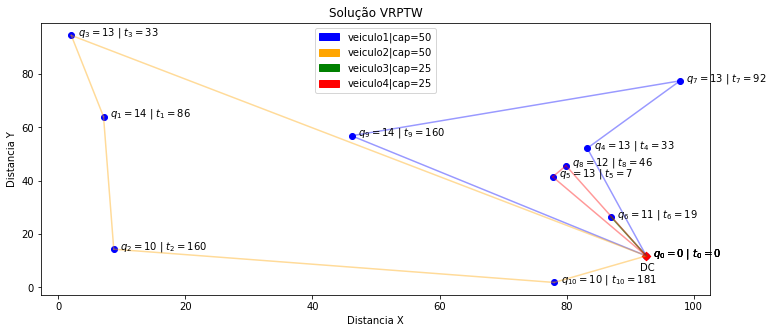

In [52]:
import matplotlib.patches as mpatches

# print grafo
plt.figure(figsize=(12,5))
plt.scatter(X,Y,color='blue')

# DC: centro de distribuição
plt.scatter(X[0],Y[0], color='red',marker='D')
plt.annotate("DC",(X[0]-1,Y[0]-5.5))

# print as rotas
for r in range(len(rotas)):
    for n in range(len(rotas[r])-1):
        i = rotas[r][n]
        j = rotas[r][n+1]
        plt.plot([X[i],X[j]],[Y[i],Y[j]],color=Color[r],alpha=0.4)

for r in range(len(tempo_acum)):
    for n in range(len(tempo_acum[r])):
        i = rotas[r][n]
        plt.annotate(
            '$q_{%d}=%d$ | $t_{%d}=%d$' %(i,q[i],i,tempo_acum[r][n]),(X[i]+1,Y[i])
        )
        
        
patch = [
    mpatches.Patch(
        color=Color[n],label="veiculo"+str(caminhoes[n])+"|cap="+str(Q[caminhoes[n]])
    )
    for n in range(len(caminhoes))
]

plt.legend(handles=patch,loc='best')
plt.xlabel("Distancia X")
plt.ylabel("Distancia Y")
plt.title("Solução VRPTW")
plt.show()